In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 1
setup_one_gpu(GPU)

Picking GPU 1


In [2]:
import sys
import numpy as np
import os.path as osp
import tensorflow as tf
import glob
import matplotlib.pylab as plt

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf


from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id
from tf_lab.autopredictors.scripts.virt_scan_data import plotting_default_params


from general_tools.notebook.tf import reset_tf_graph                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k, indices_in_iterable


from geo_tool import Point_Cloud

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader

from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
from sklearn.neighbors import NearestNeighbors

from general_tools.plotting import stack_images_horizontally, stack_images_in_square_grid

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [117]:
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'

In [114]:
# load AE model (from ICML->128 chair)
class_name = 'chair'
syn_id = shape_net_category_to_synth_id()[class_name]
ae_loss = 'emd'
ae_id = '12' # 128 bottlneck

ae_net_name = 'ae_farm_' + class_name + '_conv_arch_' + ae_id + '_2048pts_' + ae_loss
ae_net_dir = osp.join(top_data_dir, 'OUT/icml/nn_models/ae_farming', ae_net_name)
ae_conf = Conf.load(osp.join(ae_net_dir, 'configuration'))
reset_tf_graph()
ae = PointNetAutoEncoder(ae_net_name, ae_conf)

In [121]:
saved_epochs = read_saved_epochs(ae_conf.train_dir)
load_epoch = saved_epochs[-1]
ae.restore_model(ae_conf.train_dir, load_epoch, verbose=True)

Model restored in epoch 1000.


In [122]:
# Load Raw Point-Clouds of class
n_pc_samples = 2048
pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
pclouds_path = osp.join(pclouds_path, syn_id)
file_names = pio.load_filenames_of_input_data(pclouds_path, '.ply')
pclouds, model_ids, syn_ids = pio.load_crude_point_clouds(file_names=file_names, n_threads=50, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(pclouds), )

8509 files containing complete point clouds were found.


In [123]:
pcloud_data = PointCloudDataSet(pclouds, labels=model_ids, init_shuffle=False)
_, latent_codes, temp_names = latent_embedding_of_entire_dataset(pcloud_data, ae, ae_conf)
assert(np.alltrue(temp_names==model_ids))

In [124]:
top_image_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/Meshes/Shape_Net_Core/2015_Summer_OUT/Images/'
top_image_dir = osp.join(top_image_dir, syn_id)
image_view_tag = 'image_p020_t337_r005.png'

In [276]:
nn = NearestNeighbors(n_neighbors=2).fit(latent_codes)
n_objects = pcloud_data.num_examples

[5387, 2515, 60, 5211] [[ 4715.62428411  4816.20294127]]


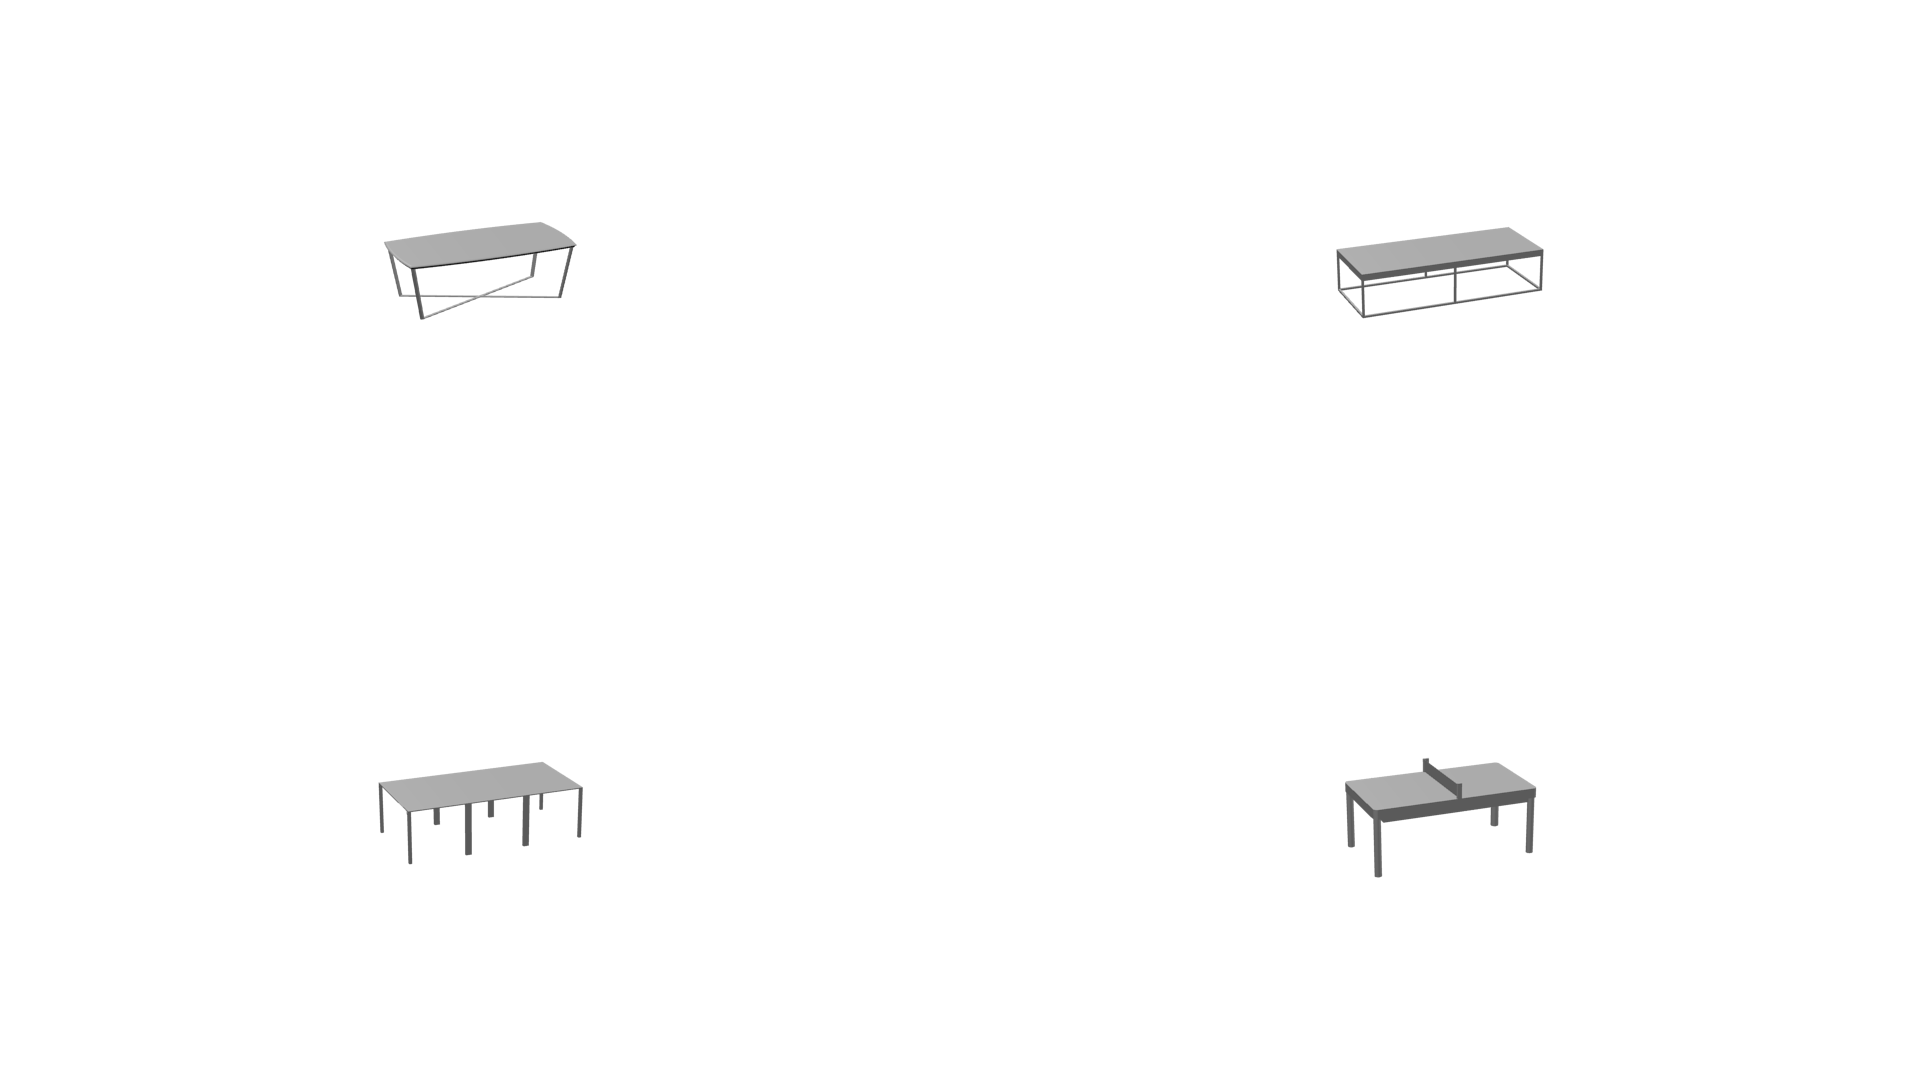

In [374]:
id1 = np.random.randint(0, n_objects)
id2 = np.random.randint(0, n_objects)
id3 = np.random.randint(0, n_objects)

id1 = 5387
id2 = 2515
id3 = np.random.randint(0, n_objects)

triplet = [id1, id2, id3]

diff = latent_codes[triplet[0]] - latent_codes[triplet[1]]

target = latent_codes[triplet[2]] - diff

distance, index = nn.kneighbors(target.reshape(1, -1))

match = index[0][0]
if  match == id3:
    print 'used second'
    match = index[0][1]

triplet.append(match)

print triplet, distance

triplet_im_files = [osp.join(top_image_dir, i, image_view_tag) for i in model_ids[triplet]]
stack_images_in_square_grid(triplet_im_files)